In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from transformator.tree import Tree
from transformator.lambda_tree import LambdaTree
import pyAgrum.lib.notebook as gnb
from collections import defaultdict

In [192]:
# N = 4
N = 6
# N = 4
REMOVE_POINTERS = False

In [193]:
ns = list(range(N-4, N+1))

In [194]:
classes = [list(LambdaTree.generate(k)) for k in ns]

In [195]:
[len(c) for c in classes]

[2, 4, 9, 22, 57]

In [196]:
# n-4:
# l^2*s^2*n*B(n)
#
# n-3:
# ((4*a*o*s*u - 2*l^2*s - 2*l*s^2)*(n - 1) + 6*a*o*s*u - 2*l^2*s - 3*l*s^2)*B(n)
# ((4*n+2)*a*o*s*u - 2*n*l^2*s - (2*n+1)*l*s^2)*B(n)
#
# n-2:
# ((-4*a*o*u + l^2 + 4*l*s + s^2)*(n - 2) - 8*u*o*a + 2*l^2 + 10*l*s + 3*s^2)*B(n)
# ((-4*n)*a*o*u + l^2*n + (4*n+2)*l*s + (n+1)*s^2)*B(n)
#
# n-1:
# ((-2*l - 2*s)*(n - 3) - 7*l - 8*s)*B(n)
# ((-2*n - 1)*l + (-2*n-2)*s)*B(n)
#
# n:
# (1 + n)*B(n)

r_ns = [
    ns[0] * len(classes[0]),
    ((4*ns[1]+2) - (2*ns[1]) - (2*ns[1]+1)) * len(classes[1]),
    (-4*ns[2] + ns[2] + (4*ns[2]+2) + (ns[2]+1)) * len(classes[2]),
    ((-2*ns[3]-1) + (-2*ns[3]-2)) * len(classes[3]),
    (ns[4] + 1) * len(classes[4]),
]

r_ns

[4, 4, 99, -506, 399]

In [197]:
sum(r_ns)

0

In [198]:
r_classes = [[] for _ in range(5)]

In [206]:
def nothing(*args, **kwargs):
    pass

def clear_r_class(k):
    r_classes[k] = []

def append_r_class_subtree_visitor(k, multiplier, visitor):
    trees = sum(
        [
            list(t.visit_subtrees(visitor))
            for t
            in classes[i]
        ],
        []
    )

    r_classes[k].append((multiplier, trees))

def skip(_):
    return lambda *args, **kwargs: None

def append_r_class_parent_subtree_visitor(k, multiplier, visitor):
    trees = sum(
        [
            list(t.visit_parent_subtrees(visitor))
            for t
            in classes[i]
        ],
        []
    )

    r_classes[k].append((multiplier, trees))

def append_r_class_left_parent_subtree_visitor(k, multiplier, visitor):
    trees = sum(
        [
            list(t.visit_left_parent_subtrees(visitor))
            for t
            in classes[i]
        ],
        []
    )

    r_classes[k].append((multiplier, trees))

def append_r_class_right_parent_subtree_visitor(k, multiplier, visitor):
    trees = sum(
        [
            list(t.visit_right_parent_subtrees(visitor))
            for t
            in classes[i]
        ],
        []
    )

    r_classes[k].append((multiplier, trees))

def compute_r_class_stats(k, show_graphs=False):
    total = 0

    if REMOVE_POINTERS:
        remove_pointers()

    if show_graphs:
        for _, trees in r_classes[k]:
            gnb.sideBySide(*[t for t in trees[:5]])

    for sub_k, (multiplier, trees) in enumerate(r_classes[k]):
        print(f"{(k, sub_k)}: {multiplier} x {len(trees)}")
        total += multiplier * len(trees)

    print(f"total: {total}")
    print(f"expected: {r_ns[k]}")

def diff_sorted(first, second, key=None, first_label="first", second_label="second"):
    key = key or (lambda x: x)

    first_generator = iter(first)
    second_generator = iter(second)

    p = None
    q = None

    p_sent = True
    q_sent = True

    try:
        p = next(first_generator)
        p_sent = False

        q = next(second_generator)
        q_sent = False

        while True:
            k_p = key(p)
            k_q = key(q)

            if k_p == k_q:
                p_sent = True
                q_sent = True

                p = next(first_generator)
                p_sent = False

                q = next(second_generator)
                q_sent = False

            elif k_p < k_q:
                yield first_label, p
                p_sent = True

                p = next(first_generator)
                p_sent = False
            else:
                yield second_label, q
                q_sent = True

                q = next(second_generator)
                q_sent = False
    except StopIteration:
        pass

    try:
        if not p_sent:
            yield first_label, p

        while True:
            yield first_label, next(first_generator)
    except StopIteration:
        pass

    try:
        if not q_sent:
            yield second_label, q

        while True:
            yield second_label, next(second_generator)
    except StopIteration:
        pass

def compute_minus_plus_diff():
    global minus
    global plus
    global diff

    minus = []
    plus = []

    for r_class_id, r_class in enumerate(r_classes):
        for r_subclass_id, (multiplier, r_subclass) in enumerate(r_class):
            for tree in r_subclass:
                data = (r_class_id, r_subclass_id, tree)

                if multiplier == -1:
                    minus.append(data)
                elif multiplier == 1:
                    plus.append(data)
                else:
                    assert False

    minus.sort(key=lambda data: str(data[2]))
    plus.sort(key=lambda data: str(data[2]))

    diff = list(diff_sorted(minus, plus, key=lambda x: str(x[2]), first_label="-", second_label="+"))

    print(f"minus: {len(minus)}")
    print(f"plus: {len(plus)}")
    print(f"diff: {len(diff)}")

    print_diff_stats()

def print_diff_stats():
    stats = defaultdict(int)
    signs = {}

    for sign, (p, q, _) in diff:
        stats[(p, q)] += 1
        signs[(p, q)] = sign

    for key in sorted(stats.keys()):
        print(f"{key}:\t{signs[key]}{stats[key]}\tof {len(r_classes[key[0]][key[1]][1])}")

def remove_pointers():
    for i in range(len(r_classes)):
        for j in range(len(r_classes[i])):
            multiplier, trees = r_classes[i][j]
            r_classes[i][j] = (multiplier, [t.with_pointers_removed() for t in trees])

_append_r_class_parent_subtree_visitor = nothing
_append_r_class_left_parent_subtree_visitor = nothing
_append_r_class_right_parent_subtree_visitor = nothing
_append_r_class_subtree_visitor = nothing

In [207]:
for i in range(4):
    clear_r_class(i)

In [208]:
# n:
# (1 + n)*B(n)

i = 4

clear_r_class(i)

# 1 + n

append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        None if kind[0] is not None else
        [kind + ("*", )] + left + right
)

print("=" * 80)
compute_r_class_stats(i)
print()
compute_minus_plus_diff()

(4, 0): 1 x 399
total: 399
expected: 399

minus: 0
plus: 399
diff: 399
(4, 0):	+399	of 399


In [209]:
# n-1:
# ((-2*n - 1)*l + (-2*n-2)*s)*B(n)

i = 3

clear_r_class(i)

# -(2*n + 1)*l

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["l", kind] + left + right + [(None, "*")]
)

append_r_class_right_parent_subtree_visitor(i, -1,
    lambda kind, parent_kind, left, right:
        None if kind[0] is not None else
        ["l", parent_kind] + [left[0] + ("*",)] + left[1:] + right + [None]
)

append_r_class_left_parent_subtree_visitor(i, -1,
    lambda kind, parent_kind, left, right:
        None if kind[0] is not None else
        ["l", parent_kind] + left + [right[0] + ("*",)] + right[1:] + [None]
)

# -2(n+1)*s

append_r_class_left_parent_subtree_visitor(i, -1,
    lambda kind, parent_kind, left, right:
        None if kind[0] is not None else
        ["s", None, parent_kind] + left + [right[0] + ("*",)] + right[1:]
)

append_r_class_right_parent_subtree_visitor(i, -1,
    lambda kind, parent_kind, left, right:
        None if kind[0] is not None else
        ["s", None, parent_kind] + [left[0] + ("*",)] + left[1:] + right
)

append_r_class_parent_subtree_visitor(i, -1,
    lambda kind, parent_kind, left, right:
        None if kind[0] is not None else
        ["s", (None, "*"), parent_kind] + left + right
)

# append_r_class_subtree_visitor(i, -1,
#     lambda kind, left, right:
#         None if kind[0] is not None else
#         ["s", (None, "*"), kind]
# )
#
# append_r_class_subtree_visitor(i, -1,
#     lambda kind, left, right:
#         None if kind[0] is not None else
#         ["s", (None, "*"), kind]
# )

print("=" * 80)
compute_r_class_stats(i)
print()
compute_minus_plus_diff()

(3, 0): -1 x 110
(3, 1): -1 x 63
(3, 2): -1 x 69
(3, 3): -1 x 69
(3, 4): -1 x 63
(3, 5): -1 x 132
total: -506
expected: -506

minus: 506
plus: 399
diff: 331
(3, 0):	-22	of 110
(3, 1):	-22	of 63
(3, 2):	-42	of 69
(3, 3):	-28	of 69
(3, 5):	-105	of 132
(4, 0):	+112	of 399


In [210]:
# n-2:
# ((-4*n)*a*o*u + l^2*n + (4*n+2)*l*s + (n+1)*s^2)*B(n)

i = 2

clear_r_class(i)

# -4(n)*a*o*u

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["a", "o", (None, "*"), None, kind] + left + right
)

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["a", "o", None, (None, "*"), kind] + left + right
)

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["a", kind] + left + right + ["o", (None, "*"), None]
)

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["a", kind] + left + right + ["o", None, (None, "*")]
)

# l^2*n

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        None if kind[0] is None else
        # ["l", "l", kind] + left + right + [None, None]
        ["l", "l", kind] + left + right + [(None, "*"), None]
)

# (4*n+2)*l*s

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        ["l", "s", (None, "*"), kind] + left + right + [None]
)

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        ["l", "s", None, kind] + left + right + [(None, "*")]
)

# (n+1)*s^2

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        None if kind[0] is not None else
        ["s", None, "s", None, kind] + left + right
)

print("=" * 80)
compute_r_class_stats(i)
print()
compute_minus_plus_diff()

(2, 0): -1 x 36
(2, 1): -1 x 36
(2, 2): -1 x 36
(2, 3): -1 x 36
total: -144
expected: 99

minus: 650
plus: 399
diff: 251
(2, 0):	-8	of 36
(2, 1):	-8	of 36
(2, 2):	-8	of 36
(2, 3):	-8	of 36
(3, 0):	-22	of 110
(3, 1):	-22	of 63
(3, 2):	-42	of 69
(3, 3):	-28	of 69
(3, 5):	-105	of 132


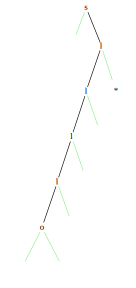

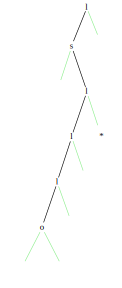

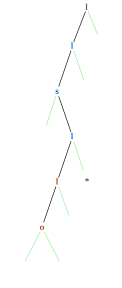

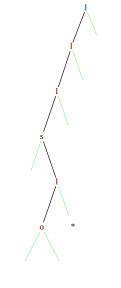

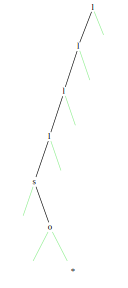

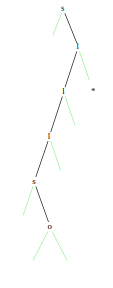

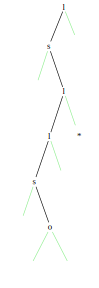

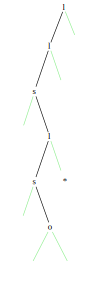

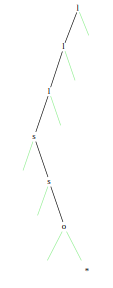

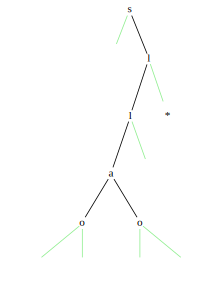

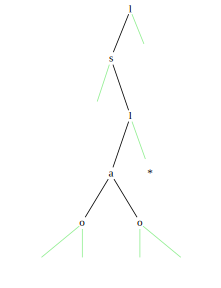

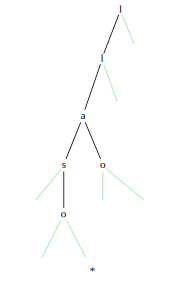

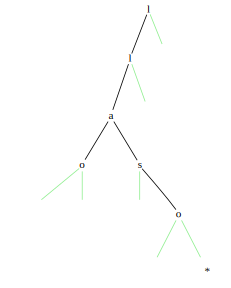

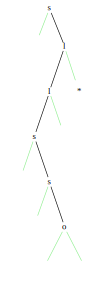

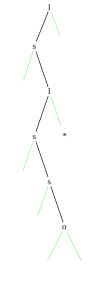

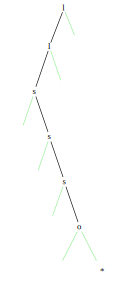

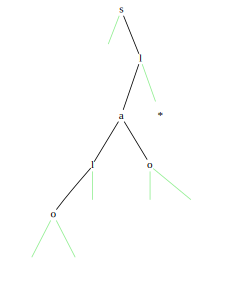

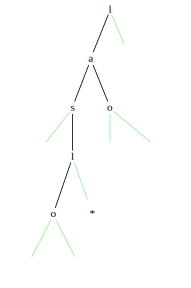

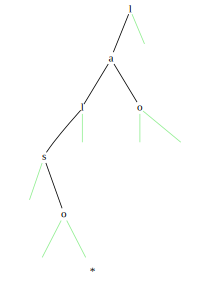

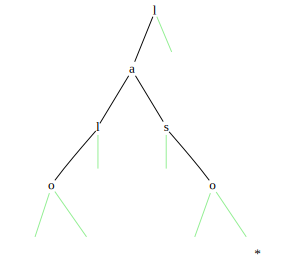

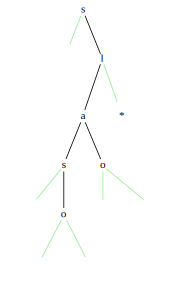

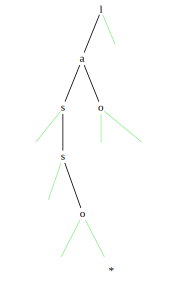

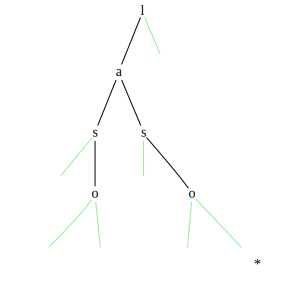

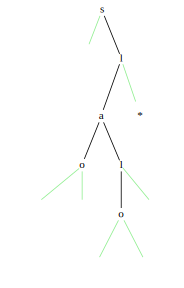

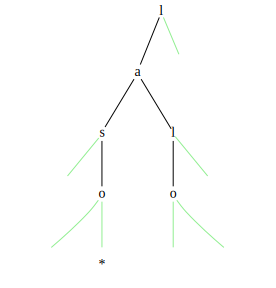

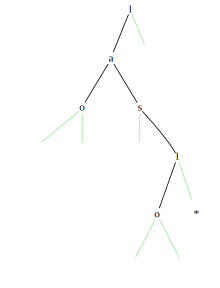

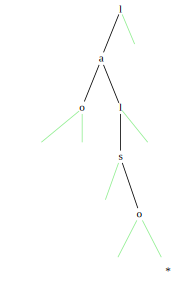

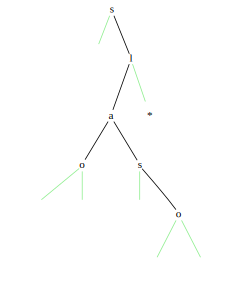

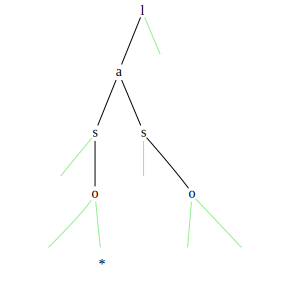

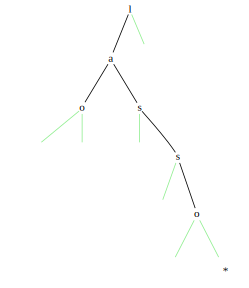

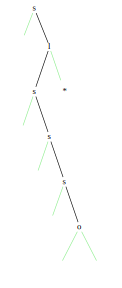

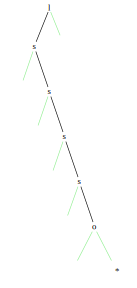

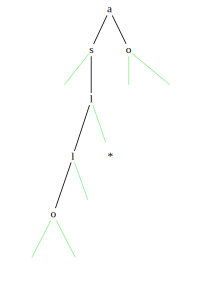

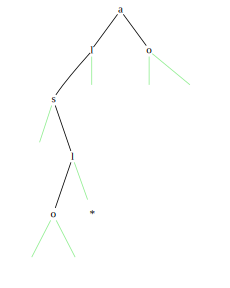

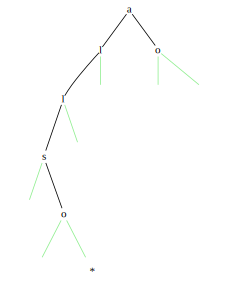

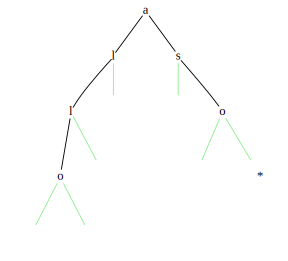

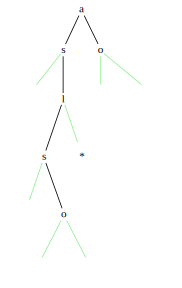

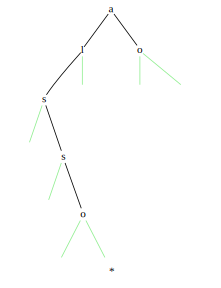

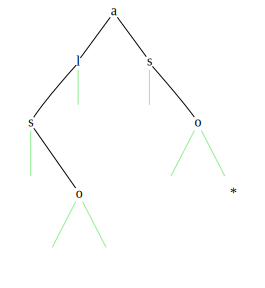

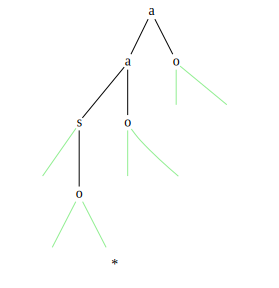

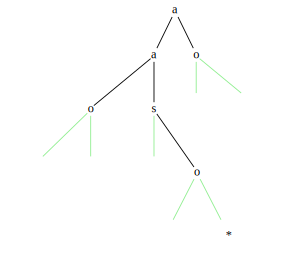

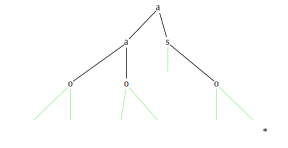

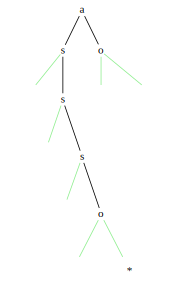

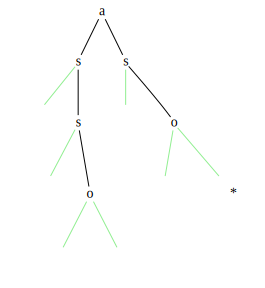

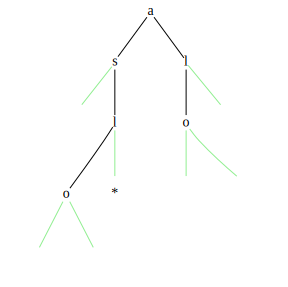

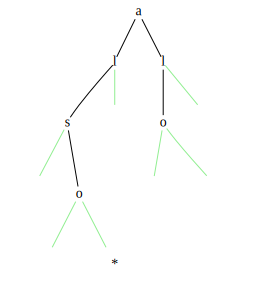

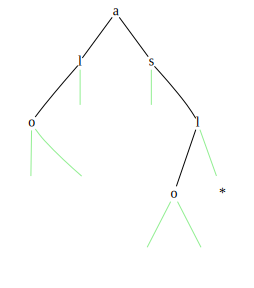

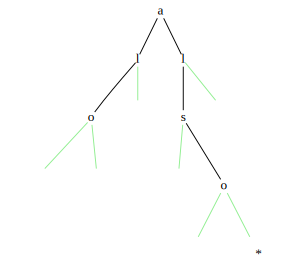

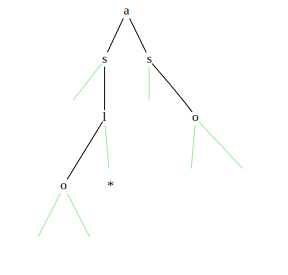

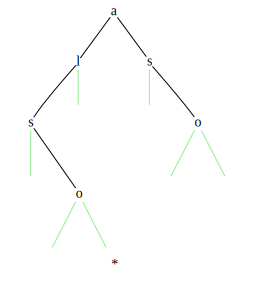

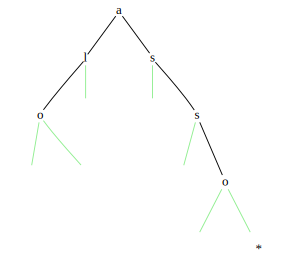

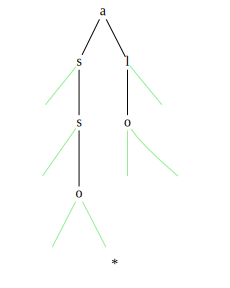

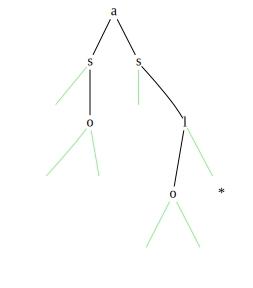

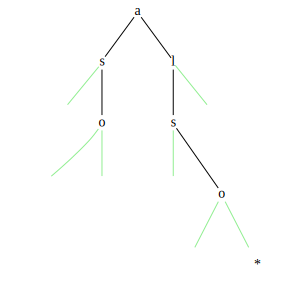

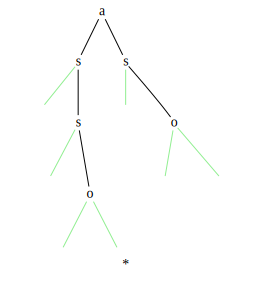

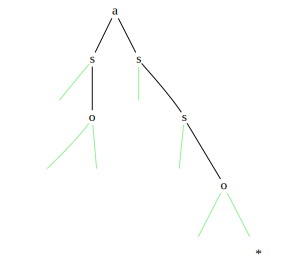

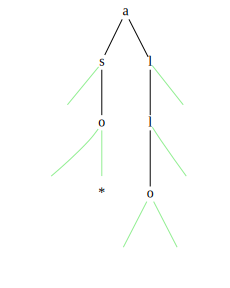

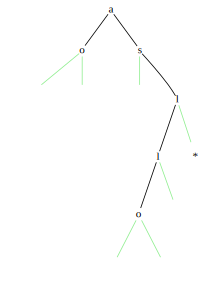

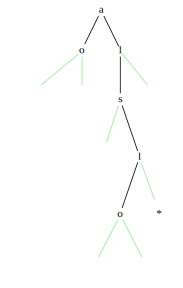

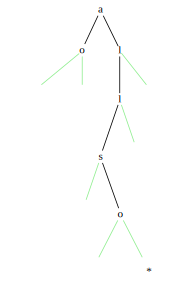

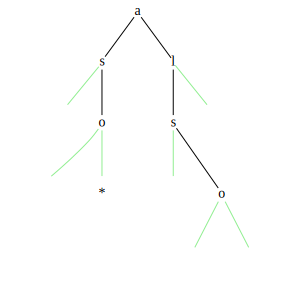

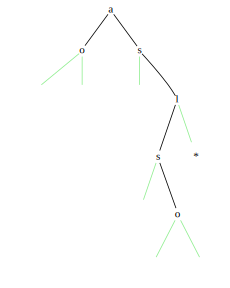

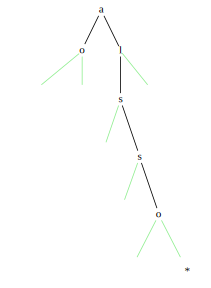

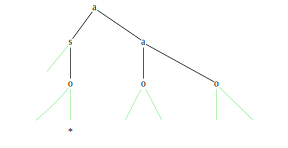

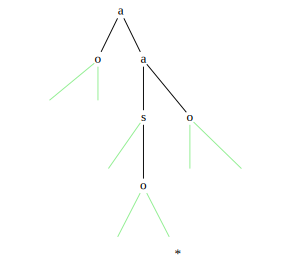

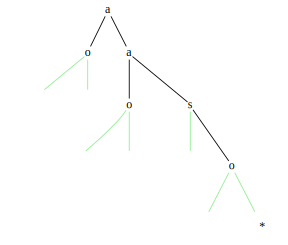

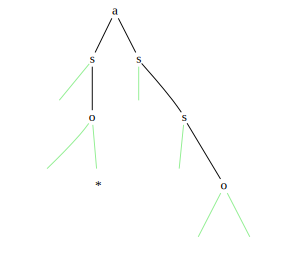

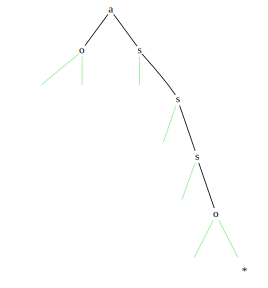

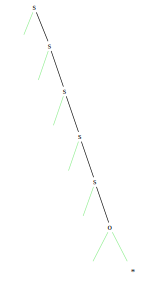

In [211]:
for i in r_classes[3][3][1]:
    display(i)

In [ ]:
for i in filter(lambda x: x[1][:2] == (3, 3), diff):
    display(i[1][2])

In [205]:
for i in filter(lambda x: x[1][:2] == (4, 0), diff):
    display(i[1][2])

In [ ]:
minus

In [ ]:
plus

In [87]:
# n-3:
# ((4*n+2)*a*o*s*u - 2*n*l^2*s - (2*n+1)*l*s^2)*B(n)

i = 1

clear_r_class(i)

# (4*n+2)*a*o*s*u

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        ["a", "s", None, "o", (None, "*"), None, kind] + left + right
)

_append_r_class_subtree_visitor(i, 1,
    lambda kind, left, right:
        ["a", "s", None, "o", None, (None, "*"), kind] + left + right
)

# - 2*n*l^2*s

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["l", "l", "s", None, kind] + left + right + [(None, "*"), None]
)

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        None if kind[0] is None else
        ["l", "l", "s", None, kind] + left + right + [None, (None, "*")]
)

# - (2*n+1)*l*s^2

append_r_class_subtree_visitor(i, -1,
    lambda kind, left, right:
        ["l", "s", None, "s", None, kind] + left + right + [None]
)

print("=" * 80)
compute_r_class_stats(i)
print()
compute_minus_plus_diff()

(1, 0): -1 x 1
(1, 1): -1 x 1
(1, 2): -1 x 3
total: -5
expected: 1

minus: 81
plus: 45
diff: 49
(1, 2):	-2	of 3
(2, 0):	-1	of 4
(2, 1):	-1	of 4
(2, 2):	-1	of 4
(2, 3):	-1	of 4
(3, 0):	-19	of 28
(3, 1):	-4	of 16
(3, 2):	-13	of 16
(4, 0):	+7	of 45


In [88]:
# n-4:
# l^2*s^2*n*B(n)

i = 0

clear_r_class(i)

# l^2*s^2*n

_append_r_class_subtree_visitor(i, 1,
        lambda kind, left, right:
            None if kind[0] is None else
            ["l", "l", "s", None, "s", None, kind] + left + right + [None, None]
)

print("=" * 80)
compute_r_class_stats(i)
print()
compute_minus_plus_diff()

total: 0
expected: 0

minus: 81
plus: 45
diff: 49
(1, 2):	-2	of 3
(2, 0):	-1	of 4
(2, 1):	-1	of 4
(2, 2):	-1	of 4
(2, 3):	-1	of 4
(3, 0):	-19	of 28
(3, 1):	-4	of 16
(3, 2):	-13	of 16
(4, 0):	+7	of 45


45

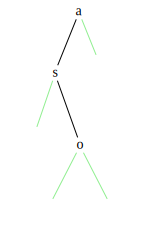

In [41]:
diff[0][1][2]

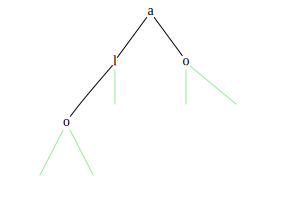

In [328]:
diff[1][1][2]

In [308]:
len(diff)

110

In [122]:
diff = diff_sorted(minus, plus, key=lambda x: str(x[2]), first_label="+", second_label="-")

In [130]:
print(next(diff))

('+', (3, 2, <a, a, o, , , o, , , o, , s, *, >))


In [131]:
diff = list(diff_sorted(minus, plus, key=lambda x: str(x[2]), first_label="+", second_label="-"))

In [132]:
len(diff)

962

In [65]:
print(diff[:10])

[('-', (4, 0, <a, a, l, o, *, , , o, , , o, , >)), ('-', (4, 0, <a, a, l, o, , *, , o, , , o, , >)), ('-', (4, 0, <a, a, o, , , l, o, *, , , o, , >)), ('-', (4, 0, <a, a, o, , , l, o, , *, , o, , >)), ('-', (4, 0, <a, a, o, , , o, , , l, o, *, , >)), ('-', (4, 0, <a, a, o, , , o, , , l, o, , *, >)), ('+', (3, 0, <a, a, o, , , o, , , o, , l, , *>)), ('+', (3, 2, <a, a, o, , , o, , , o, , s, *, >)), ('+', (3, 1, <a, a, o, , , o, , , o, , s, , *>)), ('+', (3, 0, <a, a, o, , , o, , , o, l, , *, >))]


In [66]:
len(diff)

961

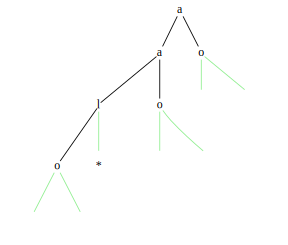

In [54]:
minus[0][2]
